In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from PIL import Image
import matplotlib.pyplot as plt


In [2]:
#Darknet层
class DarknetLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, bnorm = True, leaky = True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias = False if bnorm else True)
        self.bnorm = nn.BatchNorm2d(out_channels, eps = 1e-3) if bnorm else None
        self.leaky = nn.LeakyReLU(0.1) if leaky else None
    def forward(self, x):
        x = self.conv(x)
        if self.bnorm is not None:
            x = self.bnorm(x)
        if self.leaky is not None:
            x = self.leaky(x)
        return x


In [3]:
#DarkNet块       
class DarknetBlock(nn.Module):
    def __init__(self, layers, skip = True):
        super().__init__()
        self.skip = skip
        self.layers = nn.ModuleDict()
        for i in range(len(layers)):
            self.layers[layers[i]['id']] = DarknetLayer(layers[i]['in_channels'], layers[i]['out_channels'], layers[i]['kernel_size'],
                                                 layers[i]['stride'], layers[i]['padding'], layers[i]['bnorm'],
                                                 layers[i]['leaky'])
    def forward(self, x):
        count = 0
        for _, layer in self.layers.items():
            if count == (len(self.layers) - 2) and self.skip:
                skip_connection = x
            count += 1
            x = layer(x)
        return x + skip_connection if self.skip else x


In [4]:
#DarkNet网络
class Yolov3(nn.Module):
    def __init__(self):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners = False)
        #layer0 -> layer4, input = (3, 416, 416), flow_out = (64, 208, 208)
        self.blocks = nn.ModuleDict()
        self.blocks['block0_4'] = DarknetBlock([
            {'id': 'layer_0', 'in_channels': 3, 'out_channels': 32, 'kernel_size': 3, 'stride': 1, 'padding' : 1, 'bnorm': True, 'leaky': True},
            {'id': 'layer_1', 'in_channels': 32, 'out_channels': 64, 'kernel_size': 3, 'stride': 2, 'padding' : 1, 'bnorm': True, 'leaky': True},
            {'id': 'layer_2', 'in_channels': 64, 'out_channels': 32, 'kernel_size': 1, 'stride': 1, 'padding' : 0, 'bnorm': True, 'leaky': True},
            {'id': 'layer_3', 'in_channels': 32, 'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding' : 1, 'bnorm': True, 'leaky': True}
        ])
        #layer5 -> layer8, input = (64, 208, 208), flow_out = (128, 104, 104)
        self.blocks['block5_8'] = DarknetBlock([
            {'id': 'layer_5', 'in_channels': 64, 'out_channels': 128, 'kernel_size': 3, 'stride': 2, 'padding' : 1, 'bnorm': True, 'leaky': True},
            {'id': 'layer_6', 'in_channels': 128, 'out_channels': 64, 'kernel_size': 1, 'stride': 1, 'padding' : 0, 'bnorm': True, 'leaky': True},
            {'id': 'layer_7', 'in_channels': 64, 'out_channels': 128, 'kernel_size': 3, 'stride': 1, 'padding' : 1, 'bnorm': True, 'leaky': True}
        ])
        #layer9 -> layer11, input = (128, 104, 104), flow_out = (128, 104, 104)
        self.blocks['block9_11'] = DarknetBlock([
            {'id': 'layer_9', 'in_channels': 128, 'out_channels': 64, 'kernel_size': 1, 'stride': 1, 'padding' : 0, 'bnorm': True, 'leaky': True},
            {'id': 'layer_10', 'in_channels': 64, 'out_channels': 128, 'kernel_size': 3, 'stride': 1, 'padding' : 1, 'bnorm': True, 'leaky': True}
        ])
        #layer12 -> layer15, input = (128, 104, 104), flow_out = (256, 52, 52)
        self.blocks['block12_15'] = DarknetBlock([
            {'id': 'layer_12', 'in_channels': 128, 'out_channels': 256, 'kernel_size': 3, 'stride': 2, 'padding' : 1, 'bnorm': True, 'leaky': True},
            {'id': 'layer_13', 'in_channels': 256, 'out_channels': 128, 'kernel_size': 1, 'stride': 1, 'padding' : 0, 'bnorm': True, 'leaky': True},
            {'id': 'layer_14', 'in_channels': 128, 'out_channels': 256, 'kernel_size': 3, 'stride': 1, 'padding' : 1, 'bnorm': True, 'leaky': True}
        ])
        #layer16 -> layer36, input = (256, 52, 52), flow_out = (256, 52, 52)
        self.blocks['block16_18'] = DarknetBlock([
            {'id': 'layer_16', 'in_channels': 256, 'out_channels': 128, 'kernel_size': 1, 'stride': 1, 'padding' : 0, 'bnorm': True, 'leaky': True},
            {'id': 'layer_17', 'in_channels': 128, 'out_channels': 256, 'kernel_size': 3, 'stride': 1, 'padding' : 1, 'bnorm': True, 'leaky': True}
        ])
        self.blocks['block19_21'] = DarknetBlock([
            {'id': 'layer_19', 'in_channels': 256, 'out_channels': 128, 'kernel_size': 1, 'stride': 1, 'padding' : 0, 'bnorm': True, 'leaky': True},
            {'id': 'layer_20', 'in_channels': 128, 'out_channels': 256, 'kernel_size': 3, 'stride': 1, 'padding' : 1, 'bnorm': True, 'leaky': True}
        ])
        self.blocks['block22_24'] = DarknetBlock([
            {'id': 'layer_22', 'in_channels': 256, 'out_channels': 128, 'kernel_size': 1, 'stride': 1, 'padding' : 0, 'bnorm': True, 'leaky': True},
            {'id': 'layer_23', 'in_channels': 128, 'out_channels': 256, 'kernel_size': 3, 'stride': 1, 'padding' : 1, 'bnorm': True, 'leaky': True}
        ])
        self.blocks['block25_27'] = DarknetBlock([
            {'id': 'layer_25', 'in_channels': 256, 'out_channels': 128, 'kernel_size': 1, 'stride': 1, 'padding' : 0, 'bnorm': True, 'leaky': True},
            {'id': 'layer_26', 'in_channels': 128, 'out_channels': 256, 'kernel_size': 3, 'stride': 1, 'padding' : 1, 'bnorm': True, 'leaky': True}
        ])
        self.blocks['block28_30'] = DarknetBlock([
            {'id': 'layer_28', 'in_channels': 256, 'out_channels': 128, 'kernel_size': 1, 'stride': 1, 'padding' : 0, 'bnorm': True, 'leaky': True},
            {'id': 'layer_29', 'in_channels': 128, 'out_channels': 256, 'kernel_size': 3, 'stride': 1, 'padding' : 1, 'bnorm': True, 'leaky': True}
        ])
        self.blocks['block31_33'] = DarknetBlock([
            {'id': 'layer_31', 'in_channels': 256, 'out_channels': 128, 'kernel_size': 1, 'stride': 1, 'padding' : 0, 'bnorm': True, 'leaky': True},
            {'id': 'layer_32', 'in_channels': 128, 'out_channels': 256, 'kernel_size': 3, 'stride': 1, 'padding' : 1, 'bnorm': True, 'leaky': True}
        ])
        self.blocks['block34_36'] = DarknetBlock([
            {'id': 'layer_34', 'in_channels': 256, 'out_channels': 128, 'kernel_size': 1, 'stride': 1, 'padding' : 0, 'bnorm': True, 'leaky': True},
            {'id': 'layer_35', 'in_channels': 128, 'out_channels': 256, 'kernel_size': 3, 'stride': 1, 'padding' : 1, 'bnorm': True, 'leaky': True}
        ])
        #layer37 -> layer40, input = (256, 52, 52), flow_out = (512, 26, 26)
        self.blocks['block37_40'] = DarknetBlock([
            {'id': 'layer_37', 'in_channels': 256, 'out_channels': 512, 'kernel_size': 3, 'stride': 2, 'padding' : 1, 'bnorm': True, 'leaky': True},
            {'id': 'layer_38', 'in_channels': 512, 'out_channels': 256, 'kernel_size': 1, 'stride': 1, 'padding' : 0, 'bnorm': True, 'leaky': True},
            {'id': 'layer_39', 'in_channels': 256, 'out_channels': 512, 'kernel_size': 3, 'stride': 1, 'padding' : 1, 'bnorm': True, 'leaky': True}
        ])
        #layer41 -> layer61, input = (512, 26, 26), flow_out = (512, 26, 26)
        self.blocks['block41_43'] = DarknetBlock([
            {'id': 'layer_41', 'in_channels': 512, 'out_channels': 256, 'kernel_size': 1, 'stride': 1, 'padding' : 0, 'bnorm': True, 'leaky': True},
            {'id': 'layer_42', 'in_channels': 256, 'out_channels': 512, 'kernel_size': 3, 'stride': 1, 'padding' : 1, 'bnorm': True, 'leaky': True}
        ])
        self.blocks['block44_46'] = DarknetBlock([
            {'id': 'layer_44', 'in_channels': 512, 'out_channels': 256, 'kernel_size': 1, 'stride': 1, 'padding' : 0, 'bnorm': True, 'leaky': True},
            {'id': 'layer_45', 'in_channels': 256, 'out_channels': 512, 'kernel_size': 3, 'stride': 1, 'padding' : 1, 'bnorm': True, 'leaky': True}
        ])
        self.blocks['block47_49'] = DarknetBlock([
            {'id': 'layer_47', 'in_channels': 512, 'out_channels': 256, 'kernel_size': 1, 'stride': 1, 'padding' : 0, 'bnorm': True, 'leaky': True},
            {'id': 'layer_48', 'in_channels': 256, 'out_channels': 512, 'kernel_size': 3, 'stride': 1, 'padding' : 1, 'bnorm': True, 'leaky': True}
        ])
        self.blocks['block50_52'] = DarknetBlock([
            {'id': 'layer_50', 'in_channels': 512, 'out_channels': 256, 'kernel_size': 1, 'stride': 1, 'padding' : 0, 'bnorm': True, 'leaky': True},
            {'id': 'layer_51', 'in_channels': 256, 'out_channels': 512, 'kernel_size': 3, 'stride': 1, 'padding' : 1, 'bnorm': True, 'leaky': True}
        ])
        self.blocks['block53_55'] = DarknetBlock([
            {'id': 'layer_53', 'in_channels': 512, 'out_channels': 256, 'kernel_size': 1, 'stride': 1, 'padding' : 0, 'bnorm': True, 'leaky': True},
            {'id': 'layer_54', 'in_channels': 256, 'out_channels': 512, 'kernel_size': 3, 'stride': 1, 'padding' : 1, 'bnorm': True, 'leaky': True}
        ])
        self.blocks['block56_58'] = DarknetBlock([
            {'id': 'layer_56', 'in_channels': 512, 'out_channels': 256, 'kernel_size': 1, 'stride': 1, 'padding' : 0, 'bnorm': True, 'leaky': True},
            {'id': 'layer_57', 'in_channels': 256, 'out_channels': 512, 'kernel_size': 3, 'stride': 1, 'padding' : 1, 'bnorm': True, 'leaky': True}
        ])
        self.blocks['block59_61'] = DarknetBlock([
            {'id': 'layer_59', 'in_channels': 512, 'out_channels': 256, 'kernel_size': 1, 'stride': 1, 'padding' : 0, 'bnorm': True, 'leaky': True},
            {'id': 'layer_60', 'in_channels': 256, 'out_channels': 512, 'kernel_size': 3, 'stride': 1, 'padding' : 1, 'bnorm': True, 'leaky': True}
        ])
        #layer62 -> layer65, input = (512, 26, 26), flow_out = (1024, 13, 13)
        self.blocks['block62_65'] = DarknetBlock([
            {'id': 'layer_62', 'in_channels': 512, 'out_channels': 1024, 'kernel_size': 3, 'stride': 2, 'padding' : 1, 'bnorm': True, 'leaky': True},
            {'id': 'layer_63', 'in_channels': 1024, 'out_channels': 512, 'kernel_size': 1, 'stride': 1, 'padding' : 0, 'bnorm': True, 'leaky': True},
            {'id': 'layer_64', 'in_channels': 512, 'out_channels': 1024, 'kernel_size': 3, 'stride': 1, 'padding' : 1, 'bnorm': True, 'leaky': True}
        ])
        #layer66 -> layer74, input = (1024, 13, 13), flow_out = (1024, 13, 13)
        self.blocks['block66_68'] = DarknetBlock([
            {'id': 'layer_66', 'in_channels': 1024, 'out_channels': 512, 'kernel_size': 1, 'stride': 1, 'padding' : 0, 'bnorm': True, 'leaky': True},
            {'id': 'layer_67', 'in_channels': 512, 'out_channels': 1024, 'kernel_size': 3, 'stride': 1, 'padding' : 1, 'bnorm': True, 'leaky': True}
        ])
        self.blocks['block69_71'] = DarknetBlock([
            {'id': 'layer_69', 'in_channels': 1024, 'out_channels': 512, 'kernel_size': 1, 'stride': 1, 'padding' : 0, 'bnorm': True, 'leaky': True},
            {'id': 'layer_70', 'in_channels': 512, 'out_channels': 1024, 'kernel_size': 3, 'stride': 1, 'padding' : 1, 'bnorm': True, 'leaky': True}
        ])
        self.blocks['block72_74'] = DarknetBlock([
            {'id': 'layer_72', 'in_channels': 1024, 'out_channels': 512, 'kernel_size': 1, 'stride': 1, 'padding' : 0, 'bnorm': True, 'leaky': True},
            {'id': 'layer_73', 'in_channels': 512, 'out_channels': 1024, 'kernel_size': 3, 'stride': 1, 'padding' : 1, 'bnorm': True, 'leaky': True}
        ])
        #layer75 -> layer79, input = (1024, 13, 13), flow_out = (512, 13, 13)
        self.blocks['block75_79'] = DarknetBlock([
            {'id': 'layer_75', 'in_channels': 1024, 'out_channels': 512, 'kernel_size': 1, 'stride': 1, 'padding' : 0, 'bnorm': True, 'leaky': True},
            {'id': 'layer_76', 'in_channels': 512, 'out_channels': 1024, 'kernel_size': 3, 'stride': 1, 'padding' : 1, 'bnorm': True, 'leaky': True},
            {'id': 'layer_77', 'in_channels': 1024, 'out_channels': 512, 'kernel_size': 1, 'stride': 1, 'padding' : 0, 'bnorm': True, 'leaky': True},
            {'id': 'layer_78', 'in_channels': 512, 'out_channels': 1024, 'kernel_size': 3, 'stride': 1, 'padding' : 1, 'bnorm': True, 'leaky': True},
            {'id': 'layer_79', 'in_channels': 1024, 'out_channels': 512, 'kernel_size': 1, 'stride': 1, 'padding' : 0, 'bnorm': True, 'leaky': True}
        ], skip = False)
        #layer80 -> layer82, input = (512, 13, 13), yolo_out = (255, 13, 13)
        self.blocks['yolo_82'] = DarknetBlock([
            {'id': 'layer_80', 'in_channels': 512, 'out_channels': 1024, 'kernel_size': 3, 'stride': 1, 'padding' : 1, 'bnorm': True, 'leaky': True},
            {'id': 'layer_81', 'in_channels': 1024, 'out_channels': 255, 'kernel_size': 1, 'stride': 1, 'padding' : 0, 'bnorm': False, 'leaky': False}
        ], skip = False)
        #layer83 -> layer86, input = (512, 13, 13), -> (256, 13, 13) -> upsample and concate layer61(512, 26, 26), flow_out = (768, 26, 26)
        self.blocks['block83_86'] = DarknetBlock([
            {'id': 'layer_84', 'in_channels': 512, 'out_channels': 256, 'kernel_size': 1, 'stride': 1, 'padding' : 0, 'bnorm': True, 'leaky': True}
        ], skip = False)
        #layer87 -> layer91, input = (768, 26, 26), flow_out = (256, 26, 26)
        self.blocks['block87_91'] = DarknetBlock([
            {'id': 'layer_87', 'in_channels': 768, 'out_channels': 256, 'kernel_size': 1, 'stride': 1, 'padding' : 0, 'bnorm': True, 'leaky': True},
            {'id': 'layer_88', 'in_channels': 256, 'out_channels': 512, 'kernel_size': 3, 'stride': 1, 'padding' : 1, 'bnorm': True, 'leaky': True},
            {'id': 'layer_89', 'in_channels': 512, 'out_channels': 256, 'kernel_size': 1, 'stride': 1, 'padding' : 0, 'bnorm': True, 'leaky': True},
            {'id': 'layer_90', 'in_channels': 256, 'out_channels': 512, 'kernel_size': 3, 'stride': 1, 'padding' : 1, 'bnorm': True, 'leaky': True},
            {'id': 'layer_91', 'in_channels': 512, 'out_channels': 256, 'kernel_size': 1, 'stride': 1, 'padding' : 0, 'bnorm': True, 'leaky': True}
        ], skip = False)
        #layer92 -> layer94, input = (256, 26, 26), yolo_out = (255, 26, 26)
        self.blocks['yolo_94'] = DarknetBlock([
            {'id': 'layer_92', 'in_channels': 256, 'out_channels': 512, 'kernel_size': 3, 'stride': 1, 'padding' : 1, 'bnorm': True, 'leaky': True},
            {'id': 'layer_93', 'in_channels': 512, 'out_channels': 255, 'kernel_size': 1, 'stride': 1, 'padding' : 0, 'bnorm': False, 'leaky': False}
        ], skip = False)
        #layer95 -> layer98, input = (256, 26, 26), -> (128, 26, 26) -> upsample and concate layer36(256, 52, 52), flow_out = (384, 52, 52)
        self.blocks['block95_98'] = DarknetBlock([
            {'id': 'layer_96', 'in_channels': 256, 'out_channels': 128, 'kernel_size': 1, 'stride': 1, 'padding' : 0, 'bnorm': True, 'leaky': True}
        ], skip = False)
        #layer99 -> layer106, input = (384, 52, 52), yolo_out = (255, 52, 52)
        self.blocks['yolo_106'] = DarknetBlock([
            {'id': 'layer_99', 'in_channels': 384, 'out_channels': 128, 'kernel_size': 1, 'stride': 1, 'padding' : 0, 'bnorm': True, 'leaky': True},
            {'id': 'layer_100', 'in_channels': 128, 'out_channels': 256, 'kernel_size': 3, 'stride': 1, 'padding' : 1, 'bnorm': True, 'leaky': True},
            {'id': 'layer_101', 'in_channels': 256, 'out_channels': 128, 'kernel_size': 1, 'stride': 1, 'padding' : 0, 'bnorm': True, 'leaky': True},
            {'id': 'layer_102', 'in_channels': 128, 'out_channels': 256, 'kernel_size': 3, 'stride': 1, 'padding' : 1, 'bnorm': True, 'leaky': True},
            {'id': 'layer_103', 'in_channels': 256, 'out_channels': 128, 'kernel_size': 1, 'stride': 1, 'padding' : 0, 'bnorm': True, 'leaky': True},
            {'id': 'layer_104', 'in_channels': 128, 'out_channels': 256, 'kernel_size': 3, 'stride': 1, 'padding' : 1, 'bnorm': True, 'leaky': True},
            {'id': 'layer_105', 'in_channels': 256, 'out_channels': 255, 'kernel_size': 1, 'stride': 1, 'padding' : 0, 'bnorm': False, 'leaky': False}
        ], skip = False)
        
    def forward(self, x):
        x = self.blocks['block0_4'](x)
        x = self.blocks['block5_8'](x)
        x = self.blocks['block9_11'](x)
        x = self.blocks['block12_15'](x)
        x = self.blocks['block16_18'](x)
        x = self.blocks['block19_21'](x)
        x = self.blocks['block22_24'](x)
        x = self.blocks['block25_27'](x)
        x = self.blocks['block28_30'](x)
        x = self.blocks['block31_33'](x)
        x = self.blocks['block34_36'](x)
        skip36 = x
        x = self.blocks['block37_40'](x)
        x = self.blocks['block41_43'](x)
        x = self.blocks['block44_46'](x)
        x = self.blocks['block47_49'](x)
        x = self.blocks['block50_52'](x)
        x = self.blocks['block53_55'](x)
        x = self.blocks['block56_58'](x)
        x = self.blocks['block59_61'](x)
        skip61 = x
        x = self.blocks['block62_65'](x)
        x = self.blocks['block66_68'](x)
        x = self.blocks['block69_71'](x)
        x = self.blocks['block72_74'](x)
        x = self.blocks['block75_79'](x)
        yolo_82 = self.blocks['yolo_82'](x)
        x = self.blocks['block83_86'](x)
        x = self.upsample(x)
        x = torch.cat((x, skip61), dim = 1)
        x = self.blocks['block87_91'](x)
        yolo_94 = self.blocks['yolo_94'](x)
        x = self.blocks['block95_98'](x)
        x = self.upsample(x)
        x = torch.cat((x, skip36), dim = 1)
        yolo_106 = self.blocks['yolo_106'](x)
        return yolo_82, yolo_94, yolo_106  


In [5]:
model = Yolov3()


In [6]:
#权重读取类
class WeightReader():
    def __init__(self, weight_file):
        with open(weight_file, 'r') as fp:
            header = np.fromfile(fp, dtype = np.int32, count = 5)
            self.header = torch.from_numpy(header)
            self.seen = self.header[3]
            #The rest of the values are the weights
            #load them up
            self.weights = np.fromfile(fp, dtype = np.float32)
    #加载权重参数
    def load_weights(self, model):
        ptr = 0
        for _, block in model.blocks.items():
            for _, layer in block.layers.items():
                bn = layer.bnorm
                conv = layer.conv
                if bn is not None:
                    #Get the number of weights of Batch Norm Layer
                    num_bn_biases = bn.bias.numel()
                    #Load the data
                    #偏差
                    bn_biases = torch.from_numpy(self.weights[ptr:ptr + num_bn_biases])
                    ptr += num_bn_biases
                    #权重
                    bn_weights = torch.from_numpy(self.weights[ptr: ptr + num_bn_biases])
                    ptr  += num_bn_biases
                    #均值
                    bn_running_mean = torch.from_numpy(self.weights[ptr: ptr + num_bn_biases])
                    ptr  += num_bn_biases
                    #方差
                    bn_running_var = torch.from_numpy(self.weights[ptr: ptr + num_bn_biases])
                    ptr  += num_bn_biases
                    #Cast the loaded weights into dims of model weights. 
                    bn_biases = bn_biases.view_as(bn.bias.data)
                    bn_weights = bn_weights.view_as(bn.weight.data)
                    bn_running_mean = bn_running_mean.view_as(bn.running_mean)
                    bn_running_var = bn_running_var.view_as(bn.running_var)
                    #Copy the data to model
                    bn.bias.data.copy_(bn_biases)
                    bn.weight.data.copy_(bn_weights)
                    bn.running_mean.copy_(bn_running_mean)
                    bn.running_var.copy_(bn_running_var)  
                else:
                    #Number of biases
                    num_biases = conv.bias.numel()
                    #Load the biases
                    conv_biases = torch.from_numpy(self.weights[ptr: ptr + num_biases])
                    ptr = ptr + num_biases
                    #reshape the loaded weights according to the dims of the model weights
                    conv_biases = conv_biases.view_as(conv.bias.data)
                    #Finally copy the data
                    conv.bias.data.copy_(conv_biases)
                #load the weights for the Convolutional layers
                num_weights = conv.weight.numel()
                #Do the same as above for weights
                conv_weights = torch.from_numpy(self.weights[ptr:ptr+num_weights])
                ptr = ptr + num_weights
                conv_weights = conv_weights.view_as(conv.weight.data)
                conv.weight.data.copy_(conv_weights)
    #查看网络参数
    def weight_summary(self, model):
        train_able, train_disable = 0, 0
        for _, block in model.blocks.items():
            for _, layer in block.layers.items():
                bn = layer.bnorm
                conv = layer.conv
                if bn is not None:
                    train_able += (bn.bias.numel() + bn.weight.numel())
                    train_disable += (bn.running_mean.numel() + bn.running_var.numel())
                else:
                    train_able += conv.bias.numel()
                train_able += conv.weight.numel()
        print("total = %d"%(train_able + train_disable))
        print("count of train_able = %d"%train_able)
        print("count of train_disable = %d"%train_disable)


In [7]:
#加载模型参数，并查看模型参数数量
#####网络总参数为 62,001,757
#####其中，可训练参数(BN层以及卷积层的weight, bias) = 61,949,149， 不可训练参数(BN层的均值和方差) = 52,608
weight_reader = WeightReader('yolov3.weights')
weight_reader.load_weights(model)
weight_reader.weight_summary(model)


total = 62001757
count of train_able = 61949149
count of train_disable = 52608


In [8]:
#加载图片
def img_loader(photo_file, input_w, input_h):
    img = Image.open(photo_file)
    img_w, img_h = img.size
    img = img.resize((input_w, input_h))
    img = torchvision.transforms.ToTensor()(img)
    img = torch.unsqueeze(img, 0)
    #返回指定大小的图片张量和图片原始的宽高
    return img, img_w, img_h


In [9]:
photo_file = 'zebra.png'
input_w, input_h = 416, 416
img, img_w, img_h = img_loader(photo_file, input_w, input_h)
y_hat = model(img)


In [10]:
#锚箱类
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
        return self.score
    
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

#解码网络输出
def decode_netout(netout, anchors, obj_thresh, net_w, net_h):
    grid_h, grid_w = netout.shape[1: ]
    nb_box = 3
    netout = netout.permute(1, 2, 0).detach().numpy().reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5
    boxes = []
    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh
    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            if(objectness.all() <= obj_thresh): continue
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]
            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            boxes.append(box)
    return boxes

#执行边界框坐标的转换，将边界框列表、加载照片的原始形状和网络输入的形状作为参数。
#边界框的坐标将直接更新。
def correct_yolo_boxes(boxes, image_w, image_h, net_w, net_h):
    new_w, new_h = net_w, net_h
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

# 为计算 IoU 服务
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2,x4) - x3

#计算两个箱体的 IoU
def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union

#非极大值抑制
def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

#检索那些能强烈预测物体存在的箱子：它们的可信度超过 thresh
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):
            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                # don't break, many labels may trigger for one box
    return v_boxes, v_labels, v_scores

 #画出边界框                  
def draw_boxes(photo_file, v_boxes, v_labels, v_scores):
    # load the image
    data = plt.imread(photo_file)
    # plot the image
    plt.imshow(data)
    # get the context for drawing boxes
    ax = plt.gca()
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = plt.Rectangle((x1, y1), width, height, fill=False, color='white')
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.1f)" % (v_labels[i], v_scores[i])
        plt.text(x1, y1, label, color='white', bbox=dict(facecolor='red'))
    # show the plot
    plt.show()


In [11]:
#权重文件能够预测的标签
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
    "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
    "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
    "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]



In [12]:
def make_predict(photo_file):
    img, img_w, img_h = img_loader(photo_file, input_w, input_h)
    y_hat = model(img)
    boxes = []
    for i in range(len(y_hat)):
        # decode the output of the network
        boxes += decode_netout(y_hat[i][0], anchors[i], class_threshold, input_w, input_h)
    # correct the sizes of the bounding boxes for the shape of the image
    correct_yolo_boxes(boxes, img_w, img_h, input_w, input_h)
    # suppress non-maximal boxes
    do_nms(boxes, 0.5)
    # get the details of the detected objects
    v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
    # summarize what we found
    for i in range(len(v_boxes)):
        print(v_labels[i], v_scores[i])
    # draw what we found
    draw_boxes(photo_file, v_boxes, v_labels, v_scores)

zebra 95.83835005760193
zebra 98.92350435256958
zebra 97.53174185752869


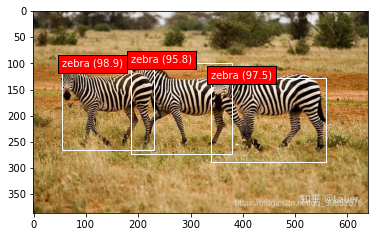

In [13]:
#预先设定的锚点
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
#输入的网络的宽高
input_w, input_h = 416, 416
#置信度阈值
class_threshold = 0.75
#读取图片开始预测
photo_file = 'zebra.png'
make_predict(photo_file)
